## Data Cleaning

We will perform an analysis of the features present 

** Basic imports **

In [13]:
%matplotlib inline
import numpy as np
import numpy.random as nd
import pandas as pd
import math
import matplotlib.pyplot as plt

import os
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display


from collections import Counter


** load data **

Here we are using a small toy dataset to explore the data

In [62]:
inputFile='../../data/smallData/rawData/AcceptedLoans.csv'
outputFile = '../../data/tmp/Simon/AcceptedLoans.csv'
data=pd.read_csv(inputFile)

In [70]:
data.shape

(39786, 145)

** check the type of the data series**

In [64]:
data.dtypes

id                                            float64
member_id                                     float64
loan_amnt                                       int64
funded_amnt                                     int64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

Check the type of data

Text(0.5,1,'types encountered in the dataset')

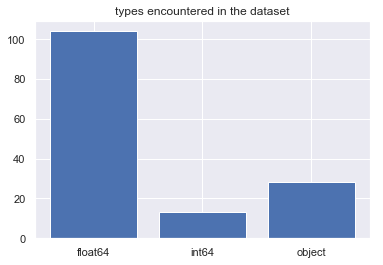

In [65]:
types=data.dtypes

typesSeen=[]
for t in types:
    if not t in typesSeen:
        typesSeen+=[t]

counts=[]
for t in typesSeen:
    counts+= [(types==t).sum()]

plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), typesSeen)
plt.title('types encountered in the dataset')

In [66]:
counts

[104, 13, 28]

## CLEAN THE OBJECT FEATURES

In [67]:
objFeatures=types[types=='object'].keys()


In [68]:
print('object features : {} entries'.format(len(objFeatures)))
print(list(objFeatures))


object features : 28 entries
['term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date']


* id

Id is indeed a float feature, I just put it here for demo

1- Outline

We will proove that `id` is an empty attribute and remove it from the dataset

2- Analysis

In [20]:
vals_id = data['id']
number_of_null_entries = vals_id.isnull().count()
number_of_entries = vals_id.shape[0]

In [21]:
print('{} empty values over {} entries'.format(number_of_null_entries, number_of_entries))
print('ratio {}%'.format(number_of_null_entries/number_of_entries *100))

42538 empty values over 42538 entries
ratio 100.0%


3- Conclusion 

`id` is an empty attribute, we can remove it

In [22]:
data=data.drop('id', axis=1)

- term

1- Outline

It can take either 36 or 60 months. It seems to fit perfectly to a categorical variable, 0 or 1.
0 for 36 months and 1 for 60 months

2- Analysis

In [71]:
data['term'].value_counts()

 36 months    29096
 60 months    10690
Name: term, dtype: int64

In [100]:
from pandas.api.types import CategoricalDtype

t = CategoricalDtype(categories=[" 36 months", " 60 months"], ordered=True)
te=  data.term.astype(t)
data['term']=te.cat.codes

In [102]:
data['term'].head()

0    0
1    1
2    0
3    0
4    1
Name: term, dtype: int8

3- Conclusion

The data.term is now a binary feature taking 0 or 1

* int_rate

1- Outline

it is a percentage, we will convert it into a float, between 0 and 100

2- Analysis

In [ ]:
def convertIntRate(s):
    """
    input : string of int_rate
    output : float between 0 and 100 corresponding to the interest rate
    """
    without_percent = s[:-1]
    number =float(without_percent)
    return(number)

In [120]:
data['int_rate']= data['int_rate'].apply(convertIntRate)

3- Conclusion

the column has been modified

In [123]:
data['int_rate'].dtype

dtype('float64')

* grade

1- Outline

This is a categorical variable with 7 levels, we will use dummy encoding

2- Analysis

In [126]:
Counter(data['grade'])

Counter({'A': 10085,
         'B': 12035,
         'C': 8111,
         'D': 5325,
         'E': 2858,
         'F': 1054,
         'G': 318})

In [130]:
dummies = pd.get_dummies(data['grade'], prefix='grade')

In [140]:
data=pd.concat([data, dummies], axis=1)


In [145]:
data=data.drop('grade', axis=1)

3- Conclusion

We removed the attribute grade and added grade_A, ...

In [150]:
data[['grade_A', 'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']].head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0


* sub_grade

1- Outline

Sub-categories of grade. categorical variable of 7*5 entries.
We could create 35 dummies but instead, we will give numerical values to the corresponding grade.

Exemple:

sub_grade = A1 --> grade_A=1

sub_grade = D4 --> grade_D=4

sub_grade = A3 --> grade_A=2

2- Analysis

In [195]:
def embed_subGrade(df):
    col, val = df['sub_grade'][0],df['sub_grade'][1]
    df['grade_'+col]=val
    return(df)

In [199]:
data = data.apply(embed_subGrade, axis=1)

In [202]:
data=data.drop('sub_grade', axis=1)

3- Conclusion 

The sub_grades have been embedded in the grades

In [206]:
data[['grade_A', 'grade_B','grade_C','grade_D','grade_E','grade_F','grade_G']].head()

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,0,2,0,0,0,0,0
1,0,0,4,0,0,0,0
2,0,0,5,0,0,0,0
3,0,0,1,0,0,0,0
4,0,5,0,0,0,0,0


* emp_title

Contains the name of the borrower'job , it does not seem to be a relevant feature for our analysis. We will remove it from the dataset

In [211]:
data=data.drop('emp_title', axis=1)

* emp_length

1- Outline

Categorical variable, we embed it using replacement. See below.

There are some missing values, we will not touch them first, but the fact that there are nan values, forces us to store this variable as float and not as int

2- Analysis

In [240]:
dict(Counter(data['emp_length']))

{nan: 1078,
 '5 years': 3286,
 '6 years': 2231,
 '10+ years': 8899,
 '4 years': 3444,
 '1 year': 3247,
 '7 years': 1775,
 '3 years': 4098,
 '2 years': 4394,
 '< 1 year': 4590,
 '9 years': 1259,
 '8 years': 1485}

In [256]:
length_to_int = dict()
length_to_int['< 1 year']=0
length_to_int['1 year']=1
length_to_int['2 years']=2
length_to_int['3 years']=3
length_to_int['4 years']=4
length_to_int['5 years']=5
length_to_int['6 years']=6
length_to_int['7 years']=7
length_to_int['8 years']=8
length_to_int['9 years']=9
length_to_int['10+ years']=10

In [257]:
length_to_int

{'1 year': 1,
 '10+ years': 10,
 '2 years': 2,
 '3 years': 3,
 '4 years': 4,
 '5 years': 5,
 '6 years': 6,
 '7 years': 7,
 '8 years': 8,
 '9 years': 9,
 '< 1 year': 0}

In [277]:
#store empty indexes
emp_length_missing = data['emp_length'].isnull()

In [267]:
def embed_emp_length(s):
    """
    convert the string emp_length into an integer
    does not change the NaN input
    """
    try:
        return(length_to_int[s])
    except:
        pass
        

In [278]:
data['emp_length']= data['emp_length'].apply(embed_emp_length)

3- Conclusion

We replaced the string inputs and did not modify the nan iputs

In [282]:
data['emp_length'].head()

0    10.0
1     0.0
2    10.0
3    10.0
4     1.0
Name: emp_length, dtype: float64

* home_ownership

categorical variable, we use dummy encoding on 4 levels : it is useless to add an extra variable for a predictor HOME_None that appears only 3 times...

In [285]:
Counter(data['home_ownership'])

Counter({'MORTGAGE': 17703,
         'NONE': 3,
         'OTHER': 98,
         'OWN': 3064,
         'RENT': 18918})

In [289]:
dum = pd.get_dummies(data['home_ownership'], prefix='HOME')
data=pd.concat([data, dum], axis=1)

In [291]:
data = data.drop('home_ownership', axis=1)

In [301]:
# remove the HOME_NONE attribute
data = data[data['HOME_NONE']==0]

In [ ]:
data=data.drop('HOME_NONE', axis=1)

In [307]:
data[['HOME_MORTGAGE', 'HOME_OTHER', 'HOME_OWN', 'HOME_RENT']].head()

,HOME_MORTGAGE,HOME_OTHER,HOME_OWN,HOME_RENT
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


* verification_status

In [310]:
Counter(data['verification_status'])

Counter({'Not Verified': 16923, 'Source Verified': 10016, 'Verified': 12844})

In [314]:
data.to_csv(outputFile, index=False)